In [62]:
%autosave 30

Autosaving every 30 seconds


# Basic Setup

## Import Liberaries

In [1]:
import numpy as np

import os
import pickle

import cv2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from mtcnn.mtcnn import MTCNN

%matplotlib inline

## Load Facenet Model

In [2]:
## Get the general path for saved model
path_saved_model=os.environ.get('DirForSavedModel')+'/face_recognisition/'
model=load_model(path_saved_model+'facenet_keras.h5')
print(model.inputs, model.outputs, sep='\n')

2021-11-01 08:50:27.967616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [41]:
face_detector = MTCNN()

# Dataset 

## Directories definition

In [3]:
base_dir = os.environ.get('DirForImages')+'/5-celebrity-faces-dataset/'

sub_dir_name = os.listdir(base_dir)
print(f"sub_directories are {sub_dir_name}")

base_dir_train  = os.path.join(base_dir, sub_dir_name[0]+'/')
base_dir_data   = os.path.join(base_dir, sub_dir_name[1]+'/')
base_dir_val    = os.path.join(base_dir, sub_dir_name[2]+'/')

sub_sub_dir = os.listdir(os.path.join(base_dir,base_dir_train))

base_dir_ben     = os.path.join(base_dir_train, sub_sub_dir[0]+'/')
base_dir_madonna = os.path.join(base_dir_train, sub_sub_dir[1]+'/')
base_dir_elton   = os.path.join(base_dir_train, sub_sub_dir[2]+'/')
base_dir_mindy   = os.path.join(base_dir_train, sub_sub_dir[3]+'/')
base_dir_jerry   = os.path.join(base_dir_train, sub_sub_dir[4]+'/')

sub_directories are ['train', 'data', 'val']


## Data Preprocessing

In [17]:
def pre_process(img, required_size=(160, 160)):
    face_data = face_detector.detect_faces(img)
    if len(face_data) == 0:
        return
    x,y,w,h = face_data[0]['box']
    face = img[y:y+h, x:x+w]
    
    resized_face = cv2.resize(face, required_size)
    normalized_face = (resized_face - resized_face.mean()) / resized_face.std()
    normalized_face = np.expand_dims(normalized_face, axis=0)
    return normalized_face, face_data

In [24]:
def get_embedding(train_dir):
    count = 0
    
    anchor_embedding = np.zeros(shape=(1,128))
    print(train_dir.split('/')[-1])
    
    for img_path in os.listdir(train_dir):
        img_path = os.path.join(train_dir, img_path)
        img = plt.imread(img_path)
        if img.shape[-1] > 3:
            continue
        processed_img, _ = pre_process(img)
        anchor_embedding += model.predict(processed_img)
        count += 1
    anchor_embedding = anchor_embedding/count
    
    return anchor_embedding

In [25]:
known_faces = {}
known_embeddings = []
parent_dir = base_dir_train
for i, dir_name in enumerate(os.listdir(parent_dir)):
    known_faces[i] = dir_name.replace("_", " ").title()
    known_embeddings.append(get_embedding(os.path.join(parent_dir, dir_name)))

known_embeddings = np.asarray(known_embeddings)
known_embeddings = np.squeeze(known_embeddings, axis=1)

print(known_faces, known_embeddings.shape)

ben_afflek
madonna
elton_john
mindy_kaling
jerry_seinfeld
{0: 'Ben Afflek', 1: 'Madonna', 2: 'Elton John', 3: 'Mindy Kaling', 4: 'Jerry Seinfeld'} (5, 128)


In [26]:
with open(path_saved_model+ "./5_celebraties_known_embeddings.txt", "wb") as fp:
    pickle.dump(known_embeddings, fp)
with open(path_saved_model+ "./known_faces.txt", "wb") as fp:
    pickle.dump(known_faces, fp)

In [ ]:
# Once you store the anchor_embeddings to your "local machine", you need not calculate them each time
# However, upload the embeddings before running this cell as they won't be in the notebook's data section

# with open("./known_embeddings.txt", "rb") as fp:
#     known_embeddings = pickle.load(fp)
# with open("./known_faces.txt", "rb") as gp:
#     known_faces = np.asarray(pickle.load(gp))

In [28]:
image= os.listdir(base_dir_ben)[2]
image_path=os.path.join(base_dir_ben, image)
img1 = plt.imread(image_path)
processed_img1, _ = pre_process(img1)
img1_embedding = model.predict(processed_img1)

In [29]:
image_madona= os.listdir(base_dir_madonna)[2]
image_path_madona=os.path.join(base_dir_madonna, image_madona)
img2 = plt.imread(image_path_madona)
processed_img1, _ = pre_process(img2)
img2_embedding = model.predict(processed_img1)

In [36]:
os.listdir(base_dir_data)

['jennifer.jpeg',
 'madonna.jpeg',
 'download (6).jpeg',
 'ben-affleck-01.jpeg',
 'images (3).jpeg',
 'ben-affleck-03.jpeg',
 'ben-affleck.jpeg',
 'madonna_eyeclosed.jpeg',
 'mindy.jpeg']

In [51]:
image_random= os.listdir(base_dir_data)[3]
image_path_random=os.path.join(base_dir_data, image_random)
img_random = plt.imread(image_path_random)
processed_img_random, _ = pre_process(img_random)
img_embedding_random = model.predict(processed_img_random)

In [59]:
newarray=img1_embedding - img_embedding_random
np.linalg.norm(newarray)

9.00013

In [60]:
np.apply_along_axis(np.linalg.norm, axis=1, arr=(img1_embedding - img_embedding_random))

array([9.00013], dtype=float32)

In [29]:
known_faces[np.argmin(np.apply_along_axis(np.linalg.norm, axis=1, arr=(known_embeddings - img2_embedding)))]

'Madonna'

In [30]:
def plot_image(img, id_code, face_data):
    top_left_x, top_left_y, width, height = face_data[0]['box']
#     plot the bounding box on the input image
#     plt.figure(figsize=(6,6))
    plt.imshow(img)
#     (0, 0.8, 0.8) == aquablue
    plt.gca().add_patch(matplotlib.patches.Rectangle((top_left_x,top_left_y), width, height,
                                                     edgecolor=(0,0.8,0.8), facecolor='none', lw=3))
    plt.gca().add_patch(matplotlib.patches.Rectangle((top_left_x,top_left_y+height), width, 0.15*height,
                                                     edgecolor=(0,0.8,0.8), facecolor=(0,0.8,0.8), lw=3, fill=True))
    plt.text(top_left_x+0.05*width, top_left_y+1.1*height, s=known_faces[id_code].split(' ')[0], color='white', size=14, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    return

In [31]:
def face_recognition(img_path, model, known_faces, known_embeddings):
    
    img = plt.imread(img_path)
    
    # refusinng RGBA format
    try:
        img.shape[-1] > 3
    except:
        print("Kindly input image with 3 color channels.")
        return
    
    #handling grayscale
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    #preprocessing the image
    processed_img, face_data = pre_process(img)
    top_left_x, top_left_y, width, height = face_data[0]['box']
    
    #getting the embeddings and the identity
    embedding = model.predict(processed_img)
    id_code = np.argmin(np.apply_along_axis(np.linalg.norm, axis=1, arr=(known_embeddings - embedding)))
    
    return img, id_code, face_data

In [33]:
import random

val_img_paths = []
val_face_id_codes = []

val_dir = base_dir_val
for i, dir_name in enumerate(os.listdir(val_dir)):
    for img_path in os.listdir(os.path.join(val_dir, dir_name)):
        val_img_paths.append(os.path.join(val_dir, dir_name, img_path))
        val_face_id_codes.append(i)
        
#shuffle
temp = list(zip(val_img_paths, val_face_id_codes))
random.shuffle(temp)
val_img_paths, val_face_id_codes = zip(*temp)
val_img_paths, val_face_id_codes = list(val_img_paths), list(val_face_id_codes)

# the above process converts lists to tuples. Later on, we need to subtract, and subtrctrion betweena a tuple and a list is not allowed. Hence, we need to explicity convert the tuple back into a list

In [34]:
#illustrative example of above code
arr0 = ['ab', 'bc', 'cd', 'de']
arr1 = [0, 1, 2, 3]
print(arr0, arr1)

arr2 = list(zip(arr0, arr1))
random.shuffle(arr2)
arr0, arr1 = zip(*arr2)
arr0, arr1 = list(arr0), list(arr1)
print(arr0, arr1)

['ab', 'bc', 'cd', 'de'] [0, 1, 2, 3]
['de', 'bc', 'ab', 'cd'] [3, 1, 0, 2]


In [36]:
predicted_codes = []
for img_path in val_img_paths:
    img, id_code, fd = face_recognition(img_path, model, known_faces, known_embeddings)
    predicted_codes.append(id_code)
print(predicted_codes)

[0, 2, 4, 3, 3, 0, 2, 2, 0, 0, 4, 2, 3, 2, 1, 4, 4, 3, 4, 1, 0, 3, 1, 1, 1]


In [37]:
# we need to use asarray to perform subtraction
np.sum(np.abs(np.asarray(val_face_id_codes) - np.asarray(predicted_codes)))

0

In [38]:
known_faces[predicted_codes[0]], known_faces[val_face_id_codes[0]]

('Ben Afflek', 'Ben Afflek')

In [41]:
from tensorflow.math import confusion_matrix
conf_mat = confusion_matrix(labels=val_face_id_codes, predictions=predicted_codes)
print(conf_mat)

tf.Tensor(
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 5]], shape=(5, 5), dtype=int32)


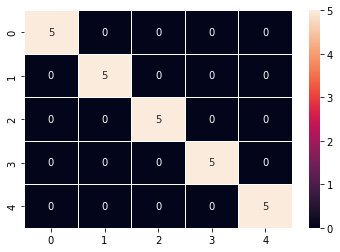

In [42]:
# import seaborn as sns
sns.heatmap(conf_mat, annot=True, linewidth=1, linecolor='w')
plt.show()

In [56]:
img_path1 = os.path.join(base_dir_data,os.listdir(base_dir_data)[2])
img1, id1, fd1 = face_recognition(img_path1, model, known_faces, known_embeddings)

img_path2 = os.path.join(base_dir_data,os.listdir(base_dir_data)[1])
img2, id2, fd2 = face_recognition(img_path2, model, known_faces, known_embeddings)

img_path3 = os.path.join(base_dir_data,os.listdir(base_dir_data)[6])
img3, id3, fd3 = face_recognition(img_path3, model, known_faces, known_embeddings)

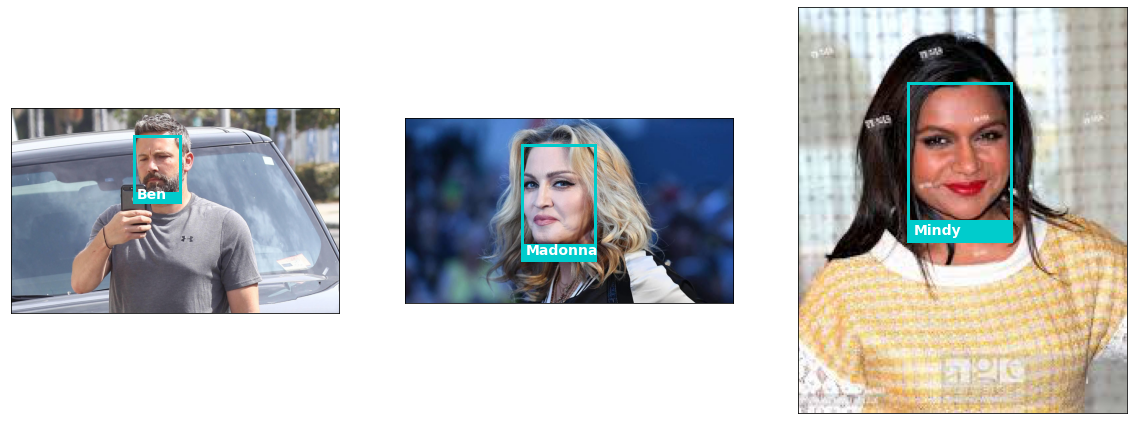

In [57]:
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plot_image(img1, id1, fd1)
plt.subplot(1,3,2)
plot_image(img2, id2, fd2)
plt.subplot(1,3,3)
plot_image(img3, id3, fd3)
plt.show()